In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

# Face detector choice

## Ground truth - annotation files

In [2]:
import xml.etree.ElementTree as ET

In [3]:
img_dir = "dataset/second_approach/images/"
annot_dir = "dataset/second_approach/annotations/"

In [4]:
annot = [file for file in glob.glob(annot_dir + "*.xml")]

### Let's see exemplary files content

In [5]:
annot1 = [annot[3]]+[annot[1]]
annot1

['dataset/second_approach/annotations/maksssksksss110.xml',
 'dataset/second_approach/annotations/maksssksksss380.xml']

In [120]:
def extract_faces(annotations, return_bdbox=False):
    images = []
    labels = []
    files = []
    for img_annot in annotations:
        tree = ET.parse(img_annot)
        root = tree.getroot()
        file = root.find('filename').text
        file_path = img_dir + file
        img = cv.imread(file_path)
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        x = img.shape[1]/width
        y = img.shape[0]/height
        objects = root.findall('object')
        for object in objects:
            label = object.find('name').text
            place = str(len(objects)) + ": " + label
            labels.append(place)
            bndbox = object.find('bndbox')
            xmin = int((int(bndbox.find('xmin').text))/x)
            ymin = int((int(bndbox.find('ymin').text))/y)
            xmax = int((int(bndbox.find('xmax').text))/x)
            ymax = int((int(bndbox.find('ymax').text))/y)
            if return_bdbox:
                images.append([xmin, ymin, xmax, ymax])
                files.append(file_path)
            else:
                face = img[ymin:ymax, xmin:xmax]
                images.append(face)
    if return_bdbox:
        return images, labels, files
    return images, labels

In [117]:
images1, labels1 = extract_faces(annot1)
len(labels1)

27

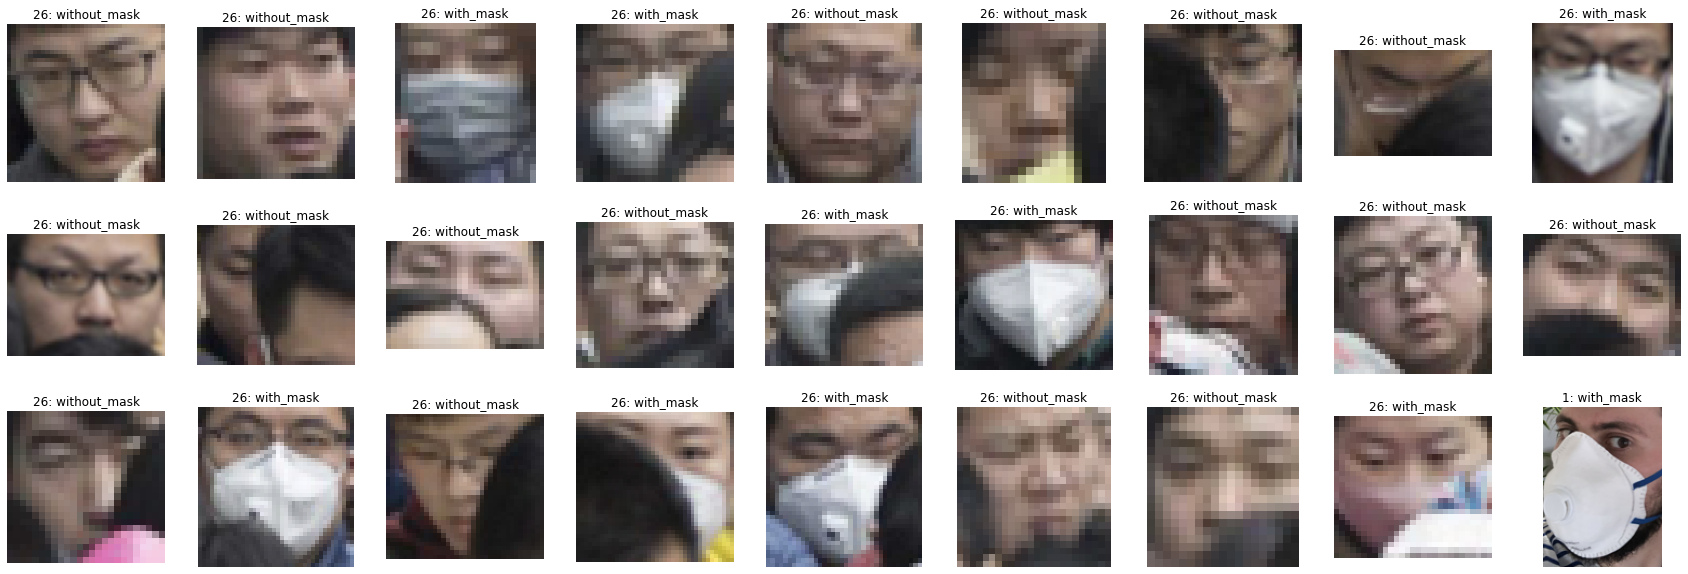

In [83]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(images1)):
    img = cv.cvtColor(images1[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(3, 9, i+1))
    plt.axis('off')
    plt.title(labels1[i])
    plt.imshow(img)   
plt.show()

What's good:
- multiple faces at one photo
- ocluded elements
- diffetent positions

## Let's take a closer look at the dataset

In [161]:
faces_on_photo = []
photo_size = []

face_sizes_area = []
face_sizes_perc = []

tiny_faces_annot = []
tiny_faces_img = []

for img_annot in annot:
    tree = ET.parse(img_annot)
    root = tree.getroot()
    objects = root.findall('object')
    faces_number = len(objects)
    faces_on_photo.append(faces_number)
    file = root.find('filename').text
    file_path = img_dir + file
    img = cv.imread(file_path)
    img_size = img.shape[0]*img.shape[1]
    photo_size.append(img_size)
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    x = img.shape[1]/width
    y = img.shape[0]/height
    for object in objects:
        bndbox = object.find('bndbox')
        xmin = int((int(bndbox.find('xmin').text))/x)
        ymin = int((int(bndbox.find('ymin').text))/y)
        xmax = int((int(bndbox.find('xmax').text))/x)
        ymax = int((int(bndbox.find('ymax').text))/y)
        area = (xmax-xmin)*(ymax-ymin)
        face_sizes_area.append(area**(0.5))
        if(area < 16):
            print("Tiny face: ", file_path, "size: ", area)
            tiny_faces_annot.append(img_annot)
            tiny_faces_img.append(file_path)
        face_sizes_perc.append(100*area/img_size)
    

Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  6
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  9
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  2
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  4
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  6
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  2
Tiny face:  dataset/second_approach/images/maksssksksss64.png size:  2
Tiny face:  dataset/second_approach/images/maksssksksss486.png size:  12
Tiny face:  dataset/second_approach/images/maksssksksss603.png size:  15


### Tiny faces?

In [169]:
tiny_faces_annot = list(set(tiny_faces_annot))
tiny_faces_img = list(set(tiny_faces_img))
tiny_faces_annot

['dataset/second_approach/annotations/maksssksksss486.xml',
 'dataset/second_approach/annotations/maksssksksss603.xml',
 'dataset/second_approach/annotations/maksssksksss64.xml']

In [171]:
tiny_faces_img = [tiny_faces_img[i] for i in [0, 2, 1]]
tiny_faces_img

['dataset/second_approach/images/maksssksksss486.png',
 'dataset/second_approach/images/maksssksksss603.png',
 'dataset/second_approach/images/maksssksksss64.png']

In [183]:
imgs2 = []
for i in tiny_faces_img:
    imgs2.append(cv.imread(i))

In [184]:
images2, labels2, files2 = extract_faces(tiny_faces_annot, return_bdbox=True)
len(labels2)

134

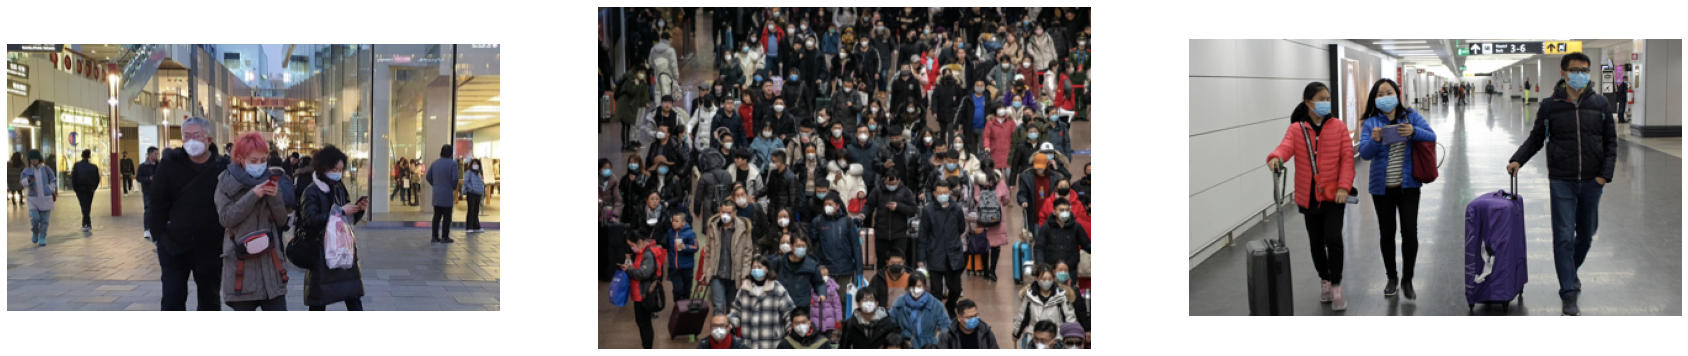

In [185]:
fig=plt.figure(figsize=(30, 10))
axes = []
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1,3, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

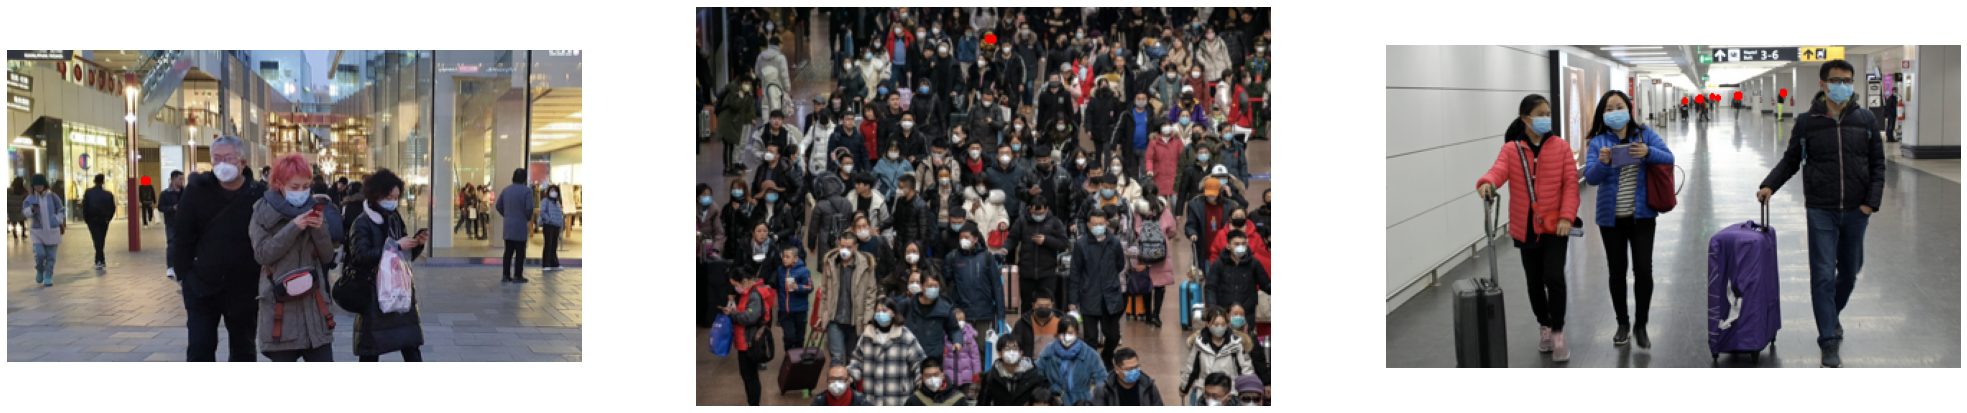

In [181]:
fig=plt.figure(figsize=(35, 40))
axes = []

for i in range(len(images2)):
    bdbox = images2[i]
    if ((bdbox[2]-bdbox[0])*(bdbox[3]-bdbox[1]) < 16):
        idx = tiny_faces_img.index(files2[i])
        cv.rectangle(imgs2[idx], (bdbox[0], bdbox[1]), (bdbox[2], bdbox[3]), (0, 0, 255), 2)
for i in range(len(imgs2)):
    img = cv.cvtColor(imgs2[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 3, i+1))
    plt.axis('off')
    plt.imshow(img) 
    

### Histograms

In [47]:
photo_size = [x / 10**3 for x in photo_size]
photo_characteristics = pd.DataFrame({'Faces on photo': faces_on_photo, 'Photo size (kilopixels)': photo_size})

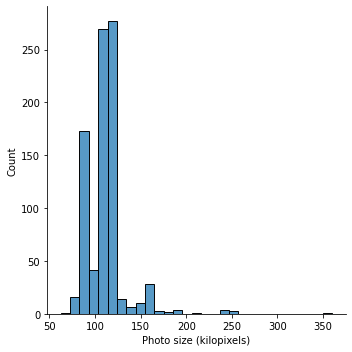

In [41]:
sns.displot(photo_characteristics, x='Photo size (kilopixels)', bins=int((len(photo_characteristics))**(0.5)))

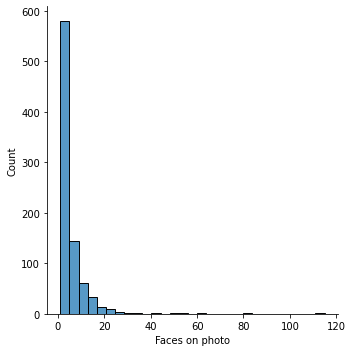

In [44]:
sns.displot(photo_characteristics, x='Faces on photo', bins=int((len(photo_characteristics))**(0.5)))

In [48]:
faces_characteristics = pd.DataFrame({'Faces area': face_sizes_area, 'Faces percentage': face_sizes_perc})

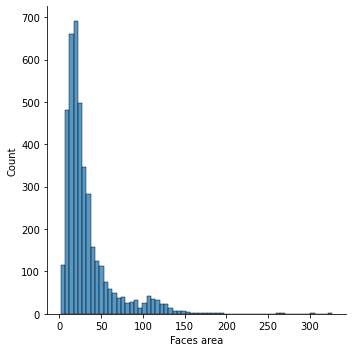

In [49]:
sns.displot(faces_characteristics, x='Faces area', bins=int((len(faces_characteristics))**(0.5)))

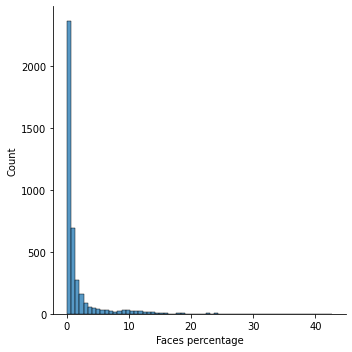

In [53]:
sns.displot(faces_characteristics, x='Faces percentage', bins=int((len(faces_characteristics))**(0.5)))

## Detector 1 - OpenCV's Haar Cascades

In [6]:
haar_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

In [7]:
def get_haar_results(detector, img):
    haar_faces = detector.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
    haar_number = len(haar_faces)
    return haar_number

## Detector 2 - OpenCV's DNN module

In [8]:
dnn_detector = cv.dnn.readNetFromCaffe("models/deploy.prototxt.txt",
                                       "models/res10_300x300_ssd_iter_140000.caffemodel")

In [9]:
def get_dnn_results(detector, img):
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)),
                                1.0, (300, 300), (104.0, 117.0, 123.0))
    detector.setInput(blob)
    detected = detector.forward()
    x = 0
    for i in range(detected.shape[2]):
        confidence = detected[0, 0, i, 2]
        if confidence > 0.5:
            x += 1
    return x

## Detector 3 - MTCNN

In [10]:
from mtcnn.mtcnn import MTCNN
mtcnn_detector = MTCNN()

In [11]:
def get_mtcnn_results(detector, img):
    faces = detector.detect_faces(img)
    return len(faces)

## Detector 4 - Dlib

In [12]:
import dlib
dlib_detector = dlib.get_frontal_face_detector()

We do not know what kind of image the user will provide - with small or big faces.

In [13]:
def get_dlib_results(detector, img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector(gray, 4)
    return len(faces)

## Detector 5 - 3DDFA

In [14]:
import importlib

In [15]:
import yaml
import matplotlib.pyplot as plt

FaceBoxes = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes')
mod_TDDFA = importlib.import_module('3DDFA_V2.TDDFA')
TDDFA = getattr(mod_TDDFA, "TDDFA")
mod_functions = importlib.import_module('3DDFA_V2.utils.functions')
draw_landmarks = getattr(mod_functions, "draw_landmarks")
mod_render = importlib.import_module('3DDFA_V2.utils.render')
render = getattr(mod_render, "render")
mod_depth = importlib.import_module('3DDFA_V2.utils.depth')
depth = getattr(mod_depth, "depth")


In [16]:
# load config
cfg = yaml.load(open('3DDFA_V2/configs/mb1_120x120.yml'), Loader=yaml.SafeLoader)

# Init FaceBoxes and TDDFA, recommend using onnx flag
onnx_flag = True  # or True to use ONNX to speed up
if onnx_flag:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    os.environ['OMP_NUM_THREADS'] = '4'
    
    mod_FaceBoxesONNX = importlib.import_module('3DDFA_V2.FaceBoxes.FaceBoxes_ONNX')
    FaceBoxes_ONNX = getattr(mod_FaceBoxesONNX, "FaceBoxes_ONNX")
    mod_TDDFA_ONNX = importlib.import_module('3DDFA_V2.TDDFA_ONNX')
    TDDFA_ONNX = getattr(mod_TDDFA_ONNX, "TDDFA_ONNX")
    
    face_boxes = FaceBoxes_ONNX()
    tddfa = TDDFA_ONNX(**cfg)
else:
    tddfa = TDDFA(gpu_mode=False, **cfg)
    face_boxes = FaceBoxes()

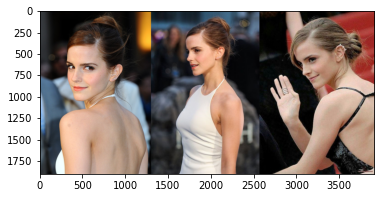

In [7]:
img_fp = '3DDFA_V2/examples/inputs/emma.jpg'
img = cv.imread(img_fp)
plt.imshow(img[..., ::-1])

In [8]:
# face detection
boxes = face_boxes(img)
print(f'Detect {len(boxes)} faces')
print(boxes)

Detect 3 faces
[[1699.8129, 278.49893, 2057.769, 762.4346, 0.9999492], [2999.3958, 304.86746, 3428.6719, 900.9679, 0.999895], [317.27078, 399.83633, 792.7348, 1048.3191, 0.99988747]]


In [9]:
# regress 3DMM params
param_lst, roi_box_lst = tddfa(img, boxes)

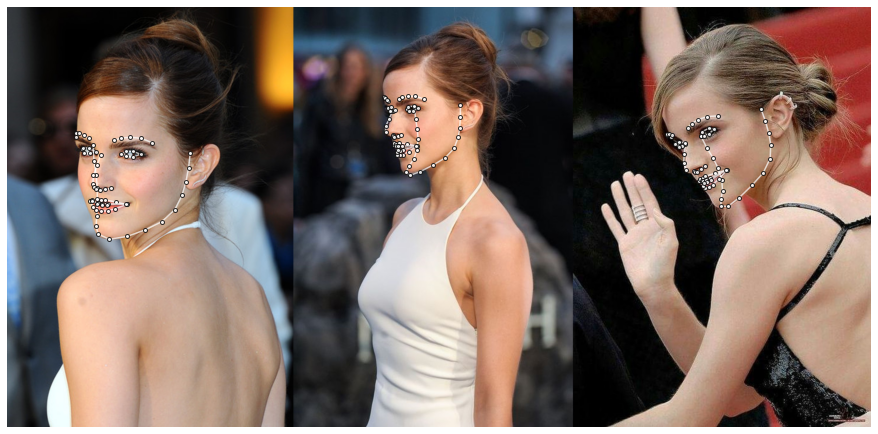

In [10]:
# reconstruct vertices and visualizing sparse landmarks
dense_flag = False
ver_lst = tddfa.recon_vers(param_lst, roi_box_lst, dense_flag=dense_flag)
draw_landmarks(img, ver_lst, dense_flag=dense_flag)

In [17]:
def get_3ddfa_results(detector, img):
    faces = detector(img)
    return len(faces)

## Detector 6 - CrowdHuman

## Test the detectors

In [40]:
detected_faces = [0]*5
undetected_faces = [0]*5
overdetected_faces = [0]*5
all_faces = 0

for img_annot in annot:
    tree = ET.parse(img_annot)
    root = tree.getroot()
    objects = root.findall('object')
    faces_number = len(objects)
    all_faces += faces_number
    
    file = root.find('filename').text
    file_path = img_dir + file
    img = cv.imread(file_path)
    
    res = [0]*5
    res[0] = get_haar_results(haar_detector, img)
    res[1] = get_dnn_results(dnn_detector, img)
    res[2] = get_mtcnn_results(mtcnn_detector, img)
    res[3] = get_dlib_results(dlib_detector, img)
    res[4] = get_3ddfa_results(face_boxes, img)
    
    for i in range(5):
        if res[i] < faces_number:
            undetected_faces[i] += (faces_number - res[i])
            detected_faces[i] += res[i]
        else:
            overdetected_faces[i] += (res[i]-faces_number)
            detected_faces[i] += faces_number
            
rows = ["haar", "dnn", "mtcnn", "dlib", "3DDFA"]
df = pd.DataFrame(data={'undetected': undetected_faces, 'detected': detected_faces,
                        'overdetected': overdetected_faces}, index=rows)
print(df)
print(all_faces)

       undetected  detected  overdetected
haar         3683       389             3
dnn          2622      1450            17
mtcnn        3075       997             4
dlib         3261       811             7
3DDFA        2625      1447            24
4072


# Dataset

## Dataset 2

### Load the data

In [ ]:
images = []
labels = []
for img_annot in annot:
    tree = ET.parse(img_annot)
    root = tree.getroot()
    file = root.find('filename').text
    file_path = img_dir + file
    img = cv.imread(file_path)
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    x = img.shape[1]/width
    y = img.shape[0]/height
    objects = root.findall('object')
    for object in objects:
        label = object.find('name').text
        labels.append(label)
        bndbox = object.find('bndbox')
        xmin = int((int(bndbox.find('xmin').text))/x)
        ymin = int((int(bndbox.find('ymin').text))/y)
        xmax = int((int(bndbox.find('xmax').text))/x)
        ymax = int((int(bndbox.find('ymax').text))/y)
        face = img[ymin:ymax, xmin:xmax]
        images.append(face)

In [ ]:
len(labels)

In [ ]:
np.unique(labels, return_counts=True)

In [ ]:
def encode(lbl):
    if lbl == 'with_mask':
        return 2
    if lbl == 'mask_weared_incorrect':
        return 1
    return 0

In [ ]:
lbls = [encode(lbl) for lbl in labels]

# Approach 1

## Load the dataset

In [416]:
masked_files = [img for img in glob.glob("dataset/first_approach/with_mask/*.jpg")]
unmasked_files = [img for img in glob.glob("dataset/first_approach/without_mask/*.jpg")]
incorrect_files = [img for img in glob.glob("dataset/first_approach/incorrect_mask/*.jpg")]
masked = [cv.imread(img) for img in masked_files if cv.imread(img) is not None]
unmasked = [cv.imread(img) for img in unmasked_files if cv.imread(img) is not None]
incorrect = [cv.imread(img) for img in incorrect_files if cv.imread(img) is not None]

## See exemplary images

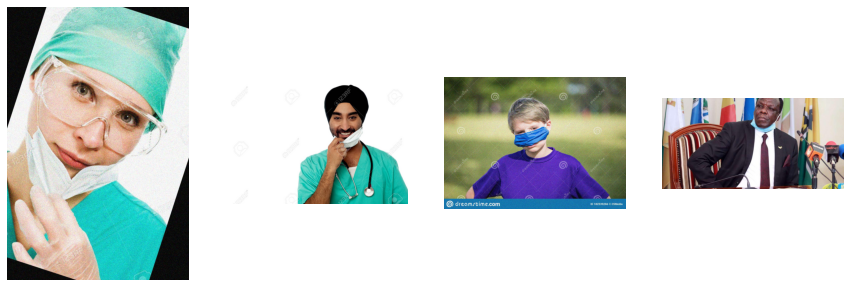

In [21]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(incorrect[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

That is not good. The images have watermarks and may be rotated.

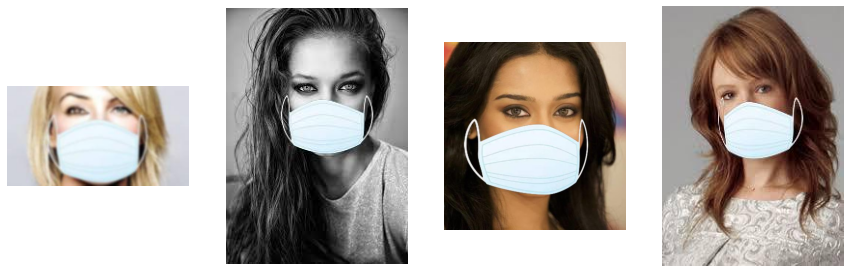

In [22]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(masked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

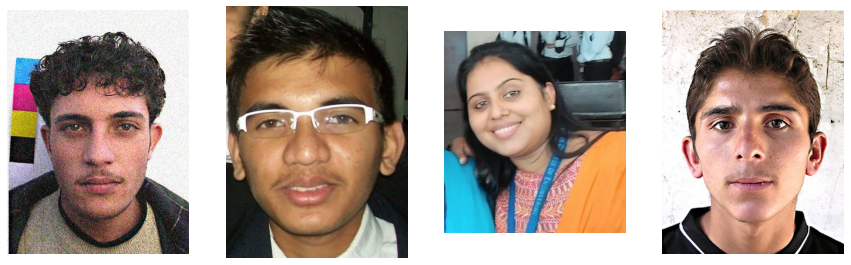

In [23]:
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(unmasked[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

## Detect faces

In this implementation I will use OpenCV's Haar Cascades.

In [32]:
face_detector = cv.CascadeClassifier('models/haarcascade_frontalface_default.xml')

To use this model, I have to convert my images into the greyscale.

The detector may detect multiple faces in the picture. I shall use them all in the next steps.

In [49]:
show_detected = [unmasked[0], masked[0], incorrect[0], unmasked[1], masked[1], incorrect[1]]

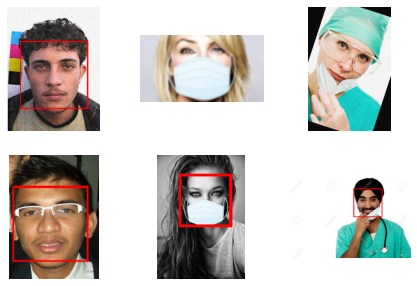

In [60]:
fig=plt.figure(figsize=(7.5, 5))
axes = []
for i in range(len(show_detected)):
    img_display = show_detected[i]
    img = cv.cvtColor(img_display, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img, scaleFactor = 1.2, minNeighbors = 5)
    for (a, b, c, d) in faces:
        cv.rectangle(img_display, (a, b), (a+c, b+d), (0, 0, 255), 2)
    img = cv.cvtColor(img_display, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(2, 3, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

In [57]:
print(len(masked))
print(len(unmasked))
print(len(incorrect))

690
686
685


The detected faces could be of different sizes - I need to rescale them before feeding them into another classifier.

In [61]:
def get_faces(img, model, scaleFactor=1.2, 
              minNeighbors=5, dimensions=(240, 240), for_display=False):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = model.detectMultiScale(img_gray, scaleFactor = scaleFactor, 
                                   minNeighbors = minNeighbors)
    extracted = []
    coords = []
    for (a, b, c, d) in faces:
        crop_img = img_gray[b:b+d, a:a+c]
        if crop_img.size != 0 and crop_img.size != 1:
            crop_img = cv.resize(crop_img, dimensions)
            extracted.append(crop_img)
    if len(extracted) == 0:
        return None
    if for_display:
        return extracted, faces
    return extracted

In [77]:
mfaces = [get_faces(image, face_detector) for image in masked]
mfaces = [face for image in mfaces if image is not None for face in image]

ufaces = [get_faces(image, face_detector) for image in unmasked]
ufaces = [face for image in ufaces if image is not None for face in image]

ifaces = [get_faces(image, face_detector) for image in incorrect]
ifaces = [face for image in ifaces if image is not None for face in image]

In [78]:
print(len(mfaces))
print(len(ufaces))
print(len(ifaces))

297
606
421


As we can see, the used face detector didn't work very well. It will most definitely hinder model's overall performance.

I should prepare the labels for the data.

## Prepare the data

In [85]:
mfaces_lbl = [2]* len(mfaces)
ifaces_lbl = [1]* len(ifaces)
ufaces_lbl = [0]* len(ufaces)
y = mfaces_lbl + ifaces_lbl + ufaces_lbl

In [102]:
 x= np.concatenate((mfaces, ifaces, ufaces))

And flatten the data for the classifier.

In [104]:
x = (np.array(x)).reshape(len(y), -1)

In [107]:
from sklearn.model_selection import train_test_split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=1, stratify=y)

## Train the classifier

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
mask_detector = RandomForestClassifier().fit(X_train, y_train)

In [111]:
mask_detector.score(X_test, y_test)

0.9169811320754717

## Let's see the application results

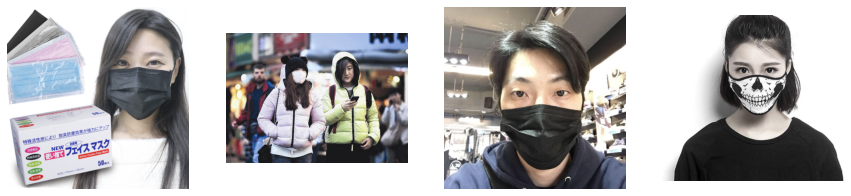

In [130]:
img1 = cv.imread("dataset/other.png")
img2 = cv.imread("dataset/other_example.png")
img3 = cv.imread("dataset/second_approach/images/maksssksksss195.png")
img4 = cv.imread("dataset/second_approach/images/maksssksksss211.png")
test_imgs = [img1, img2, img3, img4]
fig=plt.figure(figsize=(15, 10))
axes = []
for i in range(4):
    img = cv.cvtColor(test_imgs[i], cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(1, 4, i+1))
    plt.axis('off')
    plt.imshow(img)   
plt.show()

In [406]:
mask_result = ["No mask!", "Incorrect!", "Mask"]
mask_coloring = [(255, 0, 0), (255, 0, 0), (0, 255, 0)]

In [405]:
mask_coloring = [(255, 0, 0), (255, 0, 0), (0, 255, 0)]

In [123]:
font = cv.FONT_HERSHEY_SIMPLEX

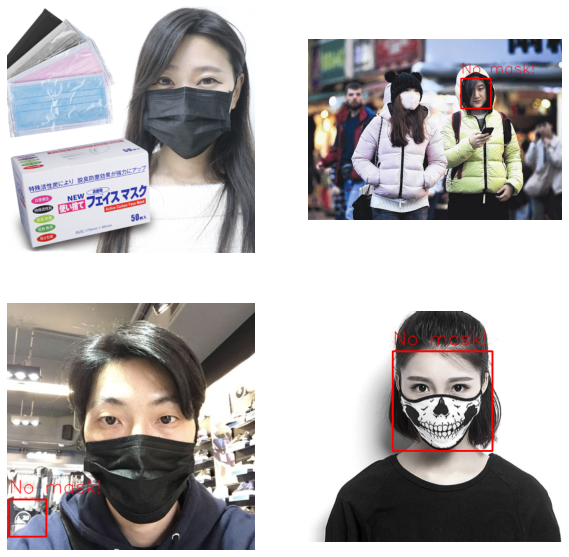

In [138]:
fig=plt.figure(figsize=(10,10))
axes = []
for i in range(4):
    img = test_imgs[i]
    if get_faces(img, face_detector) is not None:
        faces, coords = get_faces(img, face_detector, for_display=True)
        faces = [face for image in faces for face in image]
        faces_flattened = (np.array(faces)).reshape((len(coords), -1))
        res = mask_detector.predict(faces_flattened)
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        j = 0
        for coord in coords:
            cv.rectangle(img_display, (coord[0], coord[1]), (coord[0]+coord[2], coord[1]+coord[3]), mask_coloring[res[j]], 2)
            cv.putText(img_display,mask_result[res[j]],(coord[0], coord[1]-10), fontFace = font, fontScale=1, color=mask_coloring[res[j]],thickness=1, lineType=cv.LINE_AA)
            j += 1
    else:
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    axes.append(fig.add_subplot(2, 2, i+1))
    plt.axis('off')
    plt.imshow(img_display) 
plt.show()

# Approach 2

## Change of face detector

In [195]:
face_detector = cv.dnn.readNetFromCaffe("models/deploy.prototxt.txt", "models/res10_300x300_ssd_iter_140000.caffemodel")

In [388]:
def get_faces(img, model, dimensions=(240, 240), for_display=False):
    h, w = img.shape[:2]
    blob = cv.dnn.blobFromImage(cv.resize(img, (300, 300)), 1.0, (300, 300), (104.0, 117.0, 123.0))
    model.setInput(blob)
    detected = model.forward()
    extracted = []
    coordinates = []
    for i in range(detected.shape[2]):
        confidence = detected[0, 0, i, 2]
        if confidence > 0.5:
            box = detected[0, 0, i, 3:7] * np.array([w, h, w, h])
            coords = box.astype("int")
            crop_img = img[coords[1]:coords[3], coords[0]:coords[2]]
            crop_img = cv.resize(crop_img, dimensions)
            # crop_img = cv.cvtColor(crop_img, cv.COLOR_BGR2GRAY)
            extracted.append(crop_img)
            if for_display:
                coordinates.append(coords)
    if len(extracted)==0:
        return None
    if for_display:
        return extracted, coordinates
    return extracted

In [197]:
mfaces = [get_faces(image, face_detector) for image in masked]
mfaces = [face for image in mfaces if image is not None for face in image]

ufaces = [get_faces(image, face_detector) for image in unmasked]
ufaces = [face for image in ufaces if image is not None for face in image]

ifaces = [get_faces(image, face_detector) for image in incorrect]
ifaces = [face for image in ifaces if image is not None for face in image]

In [143]:
print(len(mfaces))
print(len(ufaces))
print(len(ifaces))

695
722
645


In [198]:
mfaces1 = [get_faces(image, face_detector) for image in masked]
mfaces1 = [i for i in mfaces1 if i is not None]
ufaces1 = [get_faces(image, face_detector) for image in unmasked]
ufaces1 = [i for i in ufaces1 if i is not None]
ifaces1= [get_faces(image, face_detector) for image in incorrect]
ifaces1 = [i for i in ifaces1 if i is not None]

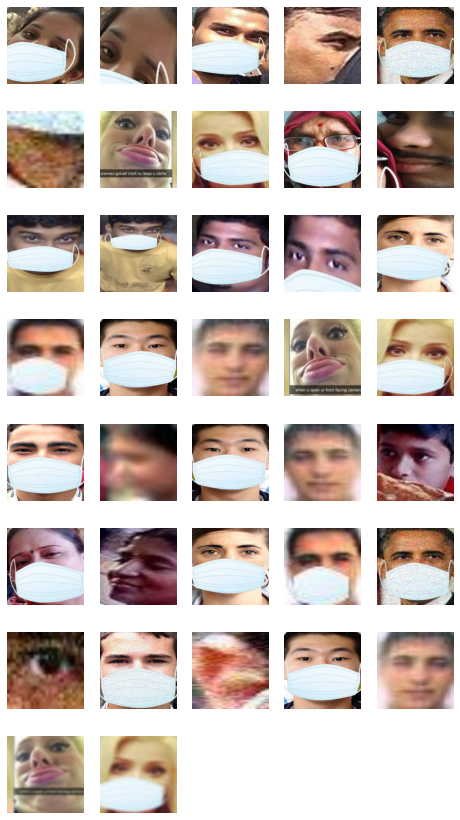

In [202]:
fig=plt.figure(figsize=(8, 15))
axes = []
j = 0
for i in range(len(mfaces1)):
    if (len(mfaces1[i]) != 1):
        for face in mfaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(8, 5, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

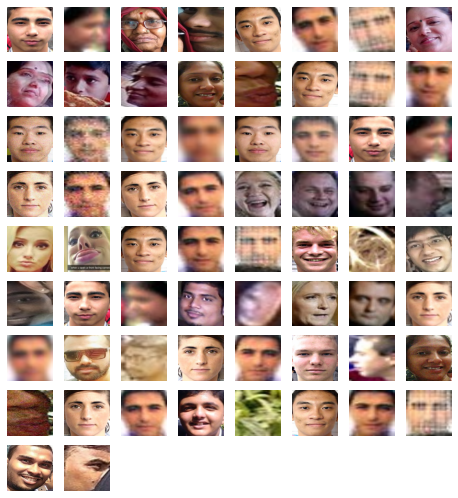

In [203]:
fig=plt.figure(figsize=(8,20))
axes = []
j = 0
for i in range(len(ufaces1)):
    if (len(ufaces1[i]) != 1):
        for face in ufaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(20, 8, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

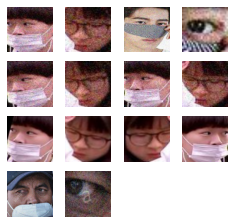

In [204]:
fig=plt.figure(figsize=(4,20))
axes = []
j = 0
for i in range(len(ifaces1)):
    if (len(ifaces1[i]) != 1):
        for face in ifaces1[i]:
            img = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            axes.append(fig.add_subplot(20, 4, j+1))
            plt.axis('off')
            plt.imshow(img)
            j += 1
        
plt.show()

# Approach 2 - old version

### Prepare for previous classifier

In [379]:
images1 = [cv.resize(face, (240, 240)) for face in images]

In [380]:
images1 = [image.flatten() for image in images1]

In [410]:
X_train, X_test, y_train, y_test = train_test_split(images1, lbls, test_size=0.2, 
                                                    random_state=1, stratify=lbls)

In [411]:
mask_detector = RandomForestClassifier().fit(X_train, y_train)
mask_detector.score(X_test, y_test)

0.9325153374233128

It seems that the results are better even for the sole dataset itself. Let's check it out on the other dataset.

In [447]:
test_imgs = [masked[1], unmasked[1], incorrect[0],
            masked[2], unmasked[2], incorrect[12]]

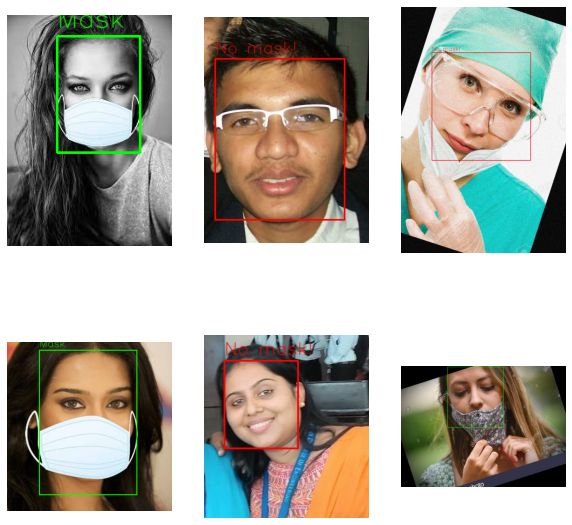

In [452]:
fig=plt.figure(figsize=(10,10))
axes = []
for i in range(6):
    img = test_imgs[i]
    if get_faces(img, face_detector) is not None:
        faces, coords = get_faces(img, face_detector, for_display=True)
        faces_flattened = (np.array(faces)).reshape((len(coords), -1))
        faces = [face for image in faces for face in image]
        res = mask_detector.predict(faces_flattened)
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        j = 0
        for coord in coords:
            cv.rectangle(img_display, (coord[0], coord[1]), (coord[2], coord[3]), mask_coloring[res[j]], 2)
            cv.putText(img_display, mask_result[res[j]],(coord[0], coord[1]-10), fontFace = font, fontScale=1, color=mask_coloring[res[j]],thickness=1, lineType=cv.LINE_AA)
            j += 1
    else:
        img_display = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        plt.title("No face detected")
    axes.append(fig.add_subplot(2, 3, i+1))
    plt.axis('off')
    plt.imshow(img_display) 
plt.show()